[4.95 3.01 3.57 ... 5.19 3.24 3.36]
not dead yet


/var/folders/p7/rnqz4ghn3cvdr6kztyk93px40000gn/T/ipykernel_50177/3362170250.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sweep_counts_norm, err = scipy.integrate.quad(f_sweep,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


459.1763488705774 73.08018567364103


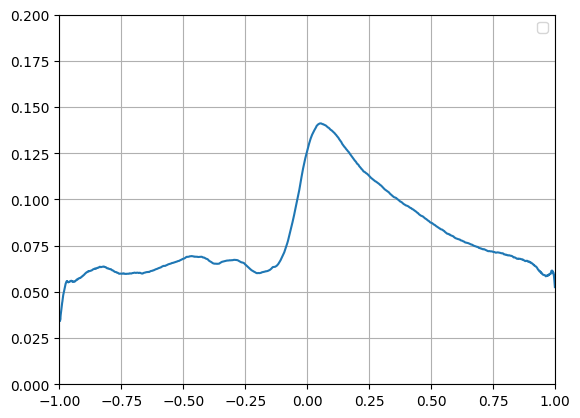

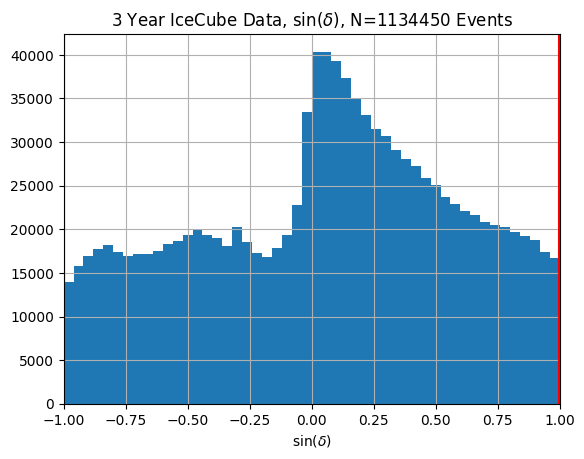

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

# Looking to calculate B_i
# we do this by scrambling data in a 6 degree
# elevation angle band in the sky
# We can't use a histogram since there is spill over between bands

# Load up the IceCube data
icecube_data = np.load("./processed_data/output_icecube_data_spacial.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["data_dec"])
data_eng = np.array(icecube_data["data_eng"])
data_day = np.array(icecube_data["data_day"])
print(data_eng)


# size of bins
size_of_band = 3.0
sweep_lowerlimit = -87.0
sweep_upperlimit = 87.0

# sweep sweep_decover different sin decs to calculate the B_i at that point
sweep_dec = np.linspace(sweep_lowerlimit, sweep_upperlimit, 1000)
sweep_eng = np.linspace(min(data_eng), max(data_eng), 1000)

print("not dead yet")

# Count number of entries in bin
entries_in_bands = np.abs(data_dec[:, np.newaxis] - sweep_dec) < size_of_band
entries_in_bands = np.sum(entries_in_bands, axis=0)





solid_angles = (2.0 * np.pi *
                np.sin(np.deg2rad(size_of_band)) *
                np.cos(np.deg2rad(sweep_dec)))
event_per_solid_angle = entries_in_bands / solid_angles
f_sweep = scipy.interpolate.interp1d(np.sin(np.deg2rad(sweep_dec)),
                                     event_per_solid_angle,
                                     kind='cubic',
                                     bounds_error=False,
                                     fill_value=0.0)
sweep_counts_norm, err = scipy.integrate.quad(f_sweep,
                                              np.sin(np.deg2rad(sweep_lowerlimit)),
                                              np.sin(np.deg2rad(sweep_upperlimit)),
                                              limit=1000)




# equation 2.2 in the paper

P_B = event_per_solid_angle /sweep_counts_norm
B_i = P_B / (2.0 * np.pi)
print(np.sum(P_B), np.sum(B_i))

np.savez("./processed_data/output_icecube_background_count_spacial.npz",
         dec=sweep_dec,
         B_i=B_i,
         eng = sweep_eng)

plt.figure()
plt.plot(np.sin(np.deg2rad(sweep_dec)), B_i)
plt.xlim(-1.0, 1.0)
plt.ylim(0.0, 0.2)
plt.legend()
plt.grid()
plt.show()


# make a figure of the data sin dec, just a raw plot
plt.figure()
plt.title("3 Year IceCube Data, $\sin(\delta)$, N="+str(len(data_dec))+" Events")
plt.hist(np.sin(np.deg2rad(data_dec)), range=(-1, 1), bins=50)
plt.xlabel("$\sin(\delta)$")
plt.xlim(-1.0, 1.0)
plt.axvline(np.sin(np.deg2rad(sweep_lowerlimit)), color='red')
plt.axvline(np.sin(np.deg2rad(sweep_upperlimit)), color='red')
plt.grid()
plt.show()

0.5176402812010011
not dead yet


/var/folders/p7/rnqz4ghn3cvdr6kztyk93px40000gn/T/ipykernel_50177/3956106123.py:55: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sweep_counts_norm, err = scipy.integrate.quad(f_sweep, -1, 1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


463.90940946635163


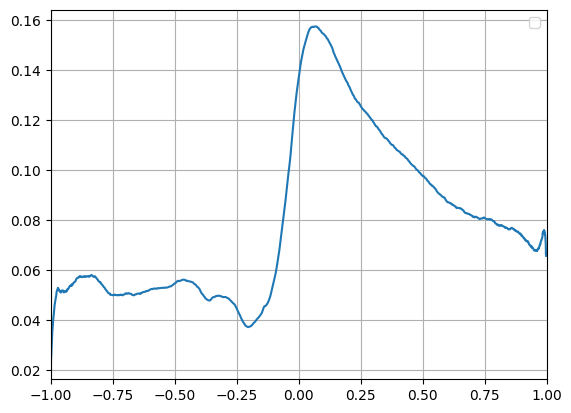

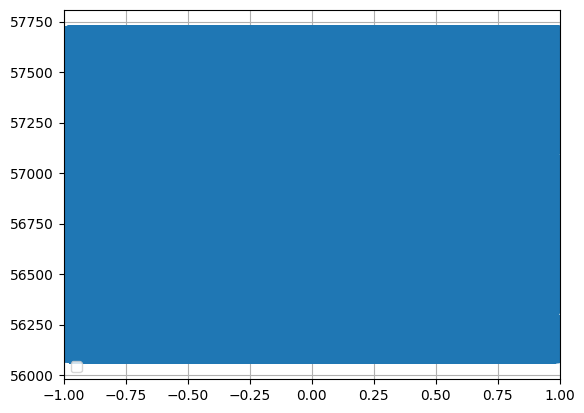

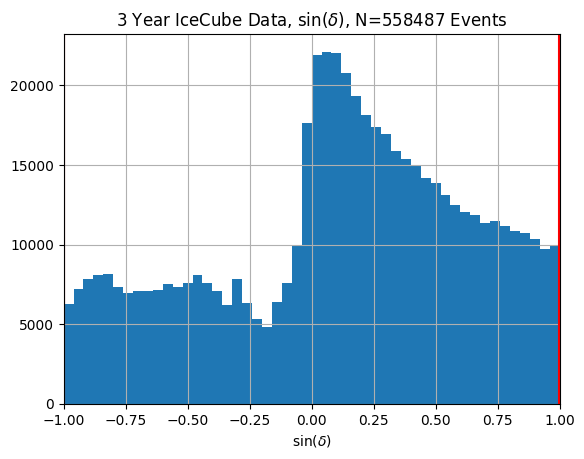

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

# Looking to calculate B_i
# we do this by scrambling data in a 6 degree
# elevation angle band in the sky
# We can't use a histogram since there is spill over between bands

# Load up the IceCube data
icecube_data = np.load("./processed_data/output_icecube_data_time.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["data_dec"])
data_eng = np.array(icecube_data["data_eng"])
data_day = np.array(icecube_data["data_day"])
data_dec = data_dec[data_day>56062]
data_eng = data_eng[data_day>56062]
data_day = data_day[data_day>56062]


print(len(data_dec[data_dec<0])/len(data_dec[data_dec>0]))


# size of bins
size_of_band = 3.0
sweep_lowerlimit = -87.0
sweep_upperlimit = 87.0

# sweep sweep_decover different sin decs to calculate the B_i at that point
sweep_dec = np.linspace(sweep_lowerlimit, sweep_upperlimit, 1000)
sweep_eng = np.linspace(min(data_eng), max(data_eng), 1000)

print("not dead yet")

# Count number of entries in bin
entries_in_bands = np.abs(data_dec[:, np.newaxis] - sweep_dec) < size_of_band
entries_in_bands = np.sum(entries_in_bands, axis=0)





solid_angles = (2.0 * np.pi *
                np.sin(np.deg2rad(size_of_band)) *
                np.cos(np.deg2rad(sweep_dec)))
event_per_solid_angle = entries_in_bands / solid_angles
f_sweep = scipy.interpolate.interp1d(np.sin(np.deg2rad(sweep_dec)),
                                     event_per_solid_angle,
                                     kind='cubic',
                                     bounds_error=False,
                                     fill_value=0.0)

# to perform the average, integrate over result and divide it out
sweep_counts_norm, err = scipy.integrate.quad(f_sweep, -1, 1)

#sweep_counts_norm_time, err_time = scipy.integrate.dblquad(f_sweep_time, min(sweep_epoch), max(sweep_epoch), -1, 1)

#B_i_time = entries_in_time_bands / sweep_counts_norm_time


# equation 2.2 in the paper
P_B = event_per_solid_angle / sweep_counts_norm
B_i = P_B / (2.0 * np.pi)
#B_i[sweep_dec<0] *= 1/26
print(np.sum(P_B))

np.savez("./processed_data/output_icecube_background_after.npz",
        dec=sweep_dec,
         B_i=B_i,
         eng = sweep_eng)

plt.figure()
plt.plot(np.sin(np.deg2rad(sweep_dec)), B_i)
plt.xlim(-1.0, 1.0)
#plt.ylim(0.0, 0.2)
plt.legend()
plt.grid()

plt.figure()
plt.plot(np.sin(np.deg2rad(data_dec)), data_day)
plt.xlim(-1.0, 1.0)
#plt.ylim(0.0, 0.2)
plt.legend()
plt.grid()


# make a figure of the data sin dec, just a raw plot
plt.figure()
plt.title("3 Year IceCube Data, $\sin(\delta)$, N="+str(len(data_dec))+" Events")
plt.hist(np.sin(np.deg2rad(data_dec)), range=(-1, 1), bins=50)
plt.xlabel("$\sin(\delta)$")
plt.xlim(-1.0, 1.0)
plt.axvline(np.sin(np.deg2rad(sweep_lowerlimit)), color='red')
plt.axvline(np.sin(np.deg2rad(sweep_upperlimit)), color='red')
plt.grid()
plt.show()

[4.95 3.01 3.57 ... 5.19 3.24 3.36]
not dead yet


/var/folders/p7/rnqz4ghn3cvdr6kztyk93px40000gn/T/ipykernel_51407/3485791636.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sweep_counts_norm, err = scipy.integrate.quad(f_sweep,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


901.4111154237759 143.46403477767296


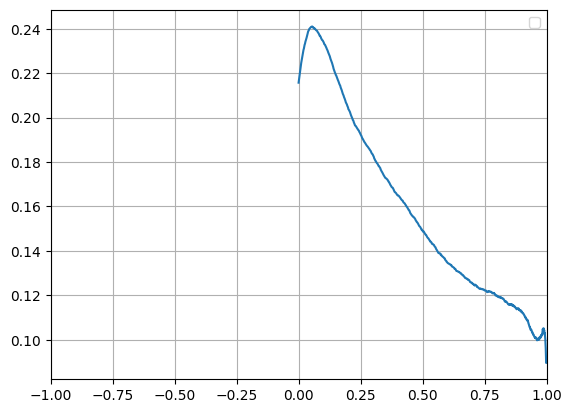

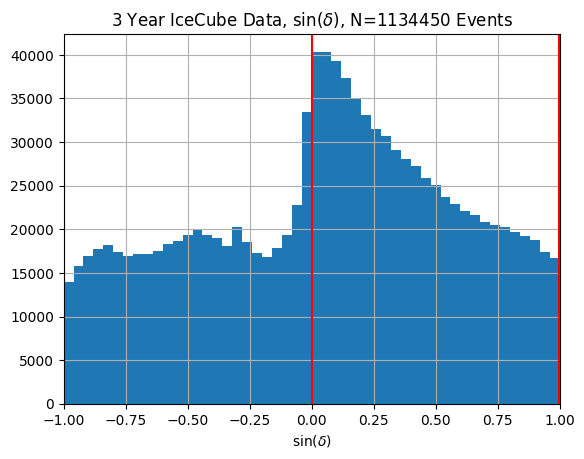

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

# Looking to calculate B_i
# we do this by scrambling data in a 6 degree
# elevation angle band in the sky
# We can't use a histogram since there is spill over between bands

# Load up the IceCube data
icecube_data = np.load("./processed_data/output_icecube_data_spacial.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["data_dec"])
data_eng = np.array(icecube_data["data_eng"])
data_day = np.array(icecube_data["data_day"])
print(data_eng)


# size of bins
size_of_band = 3.0
sweep_lowerlimit = 0
sweep_upperlimit = 87.0

# sweep sweep_decover different sin decs to calculate the B_i at that point
sweep_dec = np.linspace(sweep_lowerlimit, sweep_upperlimit, 1000)
sweep_eng = np.linspace(min(data_eng), max(data_eng), 1000)

print("not dead yet")

# Count number of entries in bin
entries_in_bands = np.abs(data_dec[:, np.newaxis] - sweep_dec) < size_of_band
entries_in_bands = np.sum(entries_in_bands, axis=0)





solid_angles = (2.0 * np.pi *
                np.sin(np.deg2rad(size_of_band)) *
                np.cos(np.deg2rad(sweep_dec)))
event_per_solid_angle = entries_in_bands / solid_angles
f_sweep = scipy.interpolate.interp1d(np.sin(np.deg2rad(sweep_dec)),
                                     event_per_solid_angle,
                                     kind='cubic',
                                     bounds_error=False,
                                     fill_value=0.00001)
sweep_counts_norm, err = scipy.integrate.quad(f_sweep,
                                              np.sin(np.deg2rad(sweep_lowerlimit)),
                                              np.sin(np.deg2rad(sweep_upperlimit)),
                                              limit=1000)




# equation 2.2 in the paper

P_B = event_per_solid_angle /sweep_counts_norm
B_i = P_B / (2.0 * np.pi)
print(np.sum(P_B), np.sum(B_i))

np.savez("./processed_data/output_icecube_background_count_energy.npz",
         dec=sweep_dec,
         B_i=B_i,
         eng = sweep_eng)

plt.figure()
plt.plot(np.sin(np.deg2rad(sweep_dec)), B_i)
plt.xlim(-1.0, 1.0)
#plt.ylim(0.0, 0.2)
plt.legend()
plt.grid()
plt.show()


# make a figure of the data sin dec, just a raw plot
plt.figure()
plt.title("3 Year IceCube Data, $\sin(\delta)$, N="+str(len(data_dec))+" Events")
plt.hist(np.sin(np.deg2rad(data_dec)), range=(-1, 1), bins=50)
plt.xlabel("$\sin(\delta)$")
plt.xlim(-1.0, 1.0)
plt.axvline(np.sin(np.deg2rad(sweep_lowerlimit)), color='red')
plt.axvline(np.sin(np.deg2rad(sweep_upperlimit)), color='red')
plt.grid()
plt.show()

In [10]:
print(min(B_i))

0.08974983494479542
